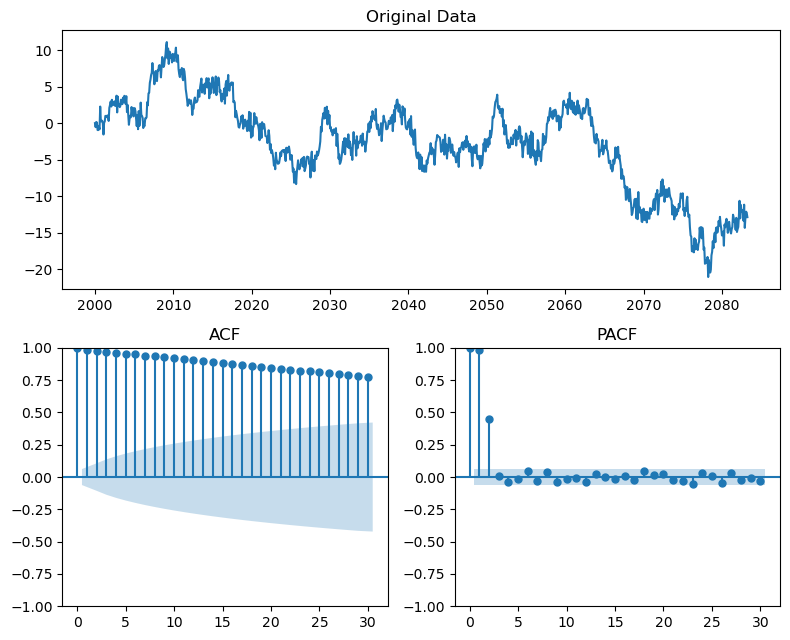

In [314]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np

test_with_artificial = True

def artificial_arima(p=np.array([]), d=0, q = np.array([]), f=lambda x:x, n = 100, m = 0):
    # generate synthetic data in order to validate our method for real data
    a  = np.random.normal(0,1,n)
    W = np.zeros(n)
    for t in range(n):   
        if t < len(p) or t < len(q):
            W[t] = 0 # maybe this can be done cleaner but whatever
        else:
            W[t] = - W[t-len(p):t] @ p[::-1] + a[t] + a[t-len(q):t] @ q[::-1] 
    
    for d_c in range(d):
        W = np.cumsum(W) 
        
    W += m    
        
    return f(W)
    
    


if test_with_artificial:
    n = 1000
    points = artificial_arima(
        p = np.array([.5]),#np.array([0,0.1,0.2]),
        q = np.array([0]),#np.array([0,0.1]),
        d = 1,
        #f = lambda x:x**2,
        n = n,
        #m = 0.01
    )
    dates = pd.date_range(start='2000-01-01', periods=n, freq='MS')
    
    # Create DataFrame with datetime index
    time_series_df = pd.DataFrame({'points': points}, index=dates)
else:
    # Load the CSV file
    time_series_df = pd.read_csv('EUR_USD_monthly.csv', 
                            parse_dates=[0],  # Parse first column as dates
                            index_col=0)  # Set first column as index
    time_series_df['points'] = time_series_df.iloc[:, 0].replace(',', '', regex=True).astype(float)

time_series_df = time_series_df.asfreq('MS')
    

    
def plot_series(series, series_title, alpha = 0.05):
    """
    Plots the time series, ACF, and PACF with custom titles in a 2-column layout.

    Parameters:
    - series: The time series data to plot.
    - series_title: Title for the time series plot.
    """
    # Create a figure with custom layout using gridspec
    fig = plt.figure(figsize=(8, 6.5))
    gs = fig.add_gridspec(2, 2)   # 1 row, 2 columns

    # First column: Time Series plot (span both rows)
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(series)
    ax0.set_title(series_title)

    # Second column: ACF and PACF plots
    # ACF plot
    ax1 = fig.add_subplot(gs[1, 0])
    plot_acf(series, ax=ax1, alpha=alpha)
    ax1.set_title("ACF")

    # PACF plot
    ax2 = fig.add_subplot(gs[1, 1])  # Reuse the same axis for PACF
    plot_pacf(series, ax=ax2, alpha=alpha)
    ax2.set_title("PACF")

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    
plot_series(time_series_df['points'], "Original Data")


Use a full automatic test to which we can compare our results to

In [315]:
if False:
    import pmdarima as pm
    
    # Automatically fit the best ARIMA/SARIMA model
    model = pm.auto_arima(
        time_series_df,
        seasonal=False,      # Enable seasonal differencing if necessary
        stepwise=True,      # Use stepwise algorithm for faster computation
        trace=True,         # Show the fitting process details
        max_p=7,              # Set maximum p value to control AR component
        max_q=7,              # Set maximum q value to control MA component
        max_d=1,              # Set maximum differencing order
        max_P=1,              # Set maximum seasonal AR order
        max_Q=1,              # Set maximum seasonal MA order
        max_D=1,
        max_order = 10
    )
    
    
    # Summary of the best model found
    print(model.summary())
    
    # Predict future values (e.g., next 12 periods)
    forecast = model.predict(n_periods=12)


Test stationarity, Augmented Dickey-Fuller unit root test.

In [316]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(-1.4130949236448684,
 0.5759823966017706,
 1,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 2804.024059191645)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

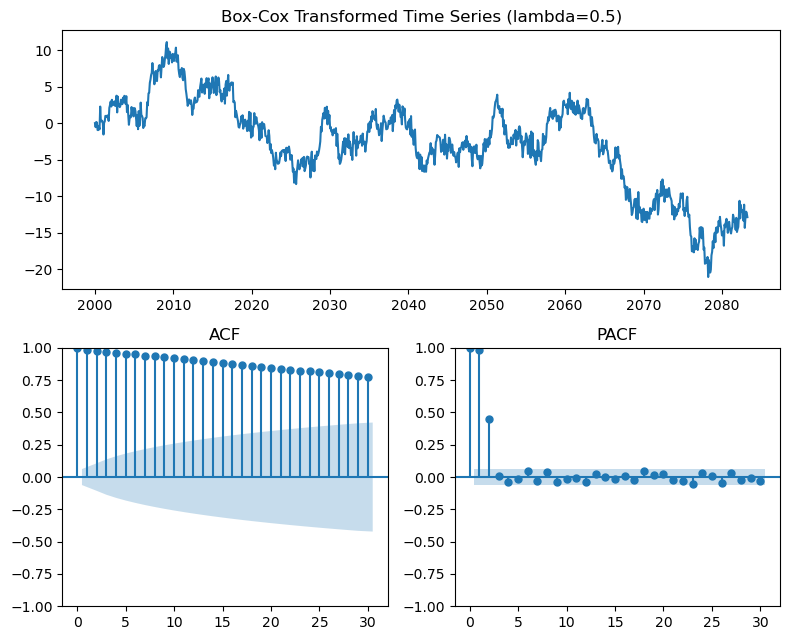

In [317]:
from scipy import stats
use_trafo = False
if use_trafo:
    # Apply Box-Cox transformation and estimate lambda
    lmbda = .5
    if lmbda is None:
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])
    else:
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda =lmbda)
    
    # Store the transformed values back into the DataFrame
    time_series_df['T_points'] = transformed_prices
    print("used lambda: ", lmbda)
else:
    time_series_df['T_points'] = time_series_df['points']
plot_series(time_series_df['T_points'], f"Box-Cox Transformed Time Series (lambda={lmbda})")
    


Differentiate and see when stationarity tests become positive

In [318]:
alpha = 0.005

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['T_points'] 
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    current_series = current_series.diff() # drop NaNs that come to existance by doing diff operation

    # Add the differenced series to the DataFrame
    time_series_df['diff_points'] = current_series.copy()
    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")


# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





After 1 differencing(s), the ADF p-value is: 0.0
Series is stationary after 1 differencings.



Plot the new time series and acf and pcf

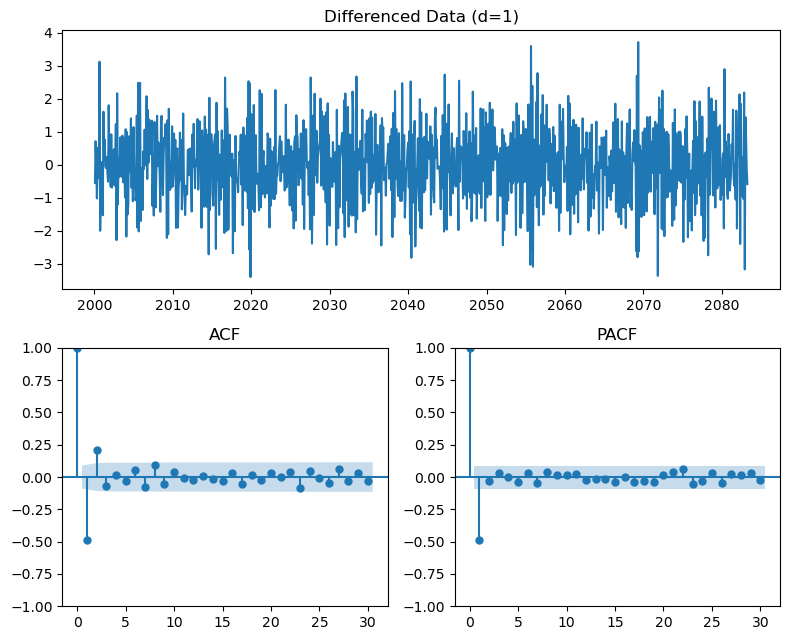

In [319]:
data = time_series_df['diff_points'].dropna() #dropnans from differentiating

plot_series(data, f"Differenced Data (d={differencing_count})", alpha = 0.005)


Print out all lags that are sginificantly non zero

In [320]:
data = time_series_df['diff_points'].dropna()

def print_significant_lags(data, alpha=0.005, nlags=40):
    """
    Calculate and print all significantly non-zero lags using ACF.
    
    Parameters:
    -----------
    data : array-like
        The time series data
    alpha : float, default=0.05
        Significance level for the confidence intervals
    nlags : int, default=40
        Number of lags to calculate
    
    Returns:
    --------
    tuple
        - List of significant lag indices
        - ACF values for significant lags
        - Confidence intervals
    """
    # Calculate ACF with confidence intervals
    acf_values, acf_confint = st.acf(data, alpha=alpha, fft=True, nlags=nlags, adjusted=True)
    pacf_values, pacf_confint = st.pacf(data, alpha=alpha, nlags=nlags)
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    acf_significant_lags = []
    acf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | ACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(acf_values)):
        lower_ci = acf_confint[lag][0]
        upper_ci = acf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            acf_significant_lags.append(lag)
            acf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {acf_values[lag]:9.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    pacf_significant_lags = []
    pacf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | PACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(pacf_values)):
        lower_ci = pacf_confint[lag][0]
        upper_ci = pacf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            pacf_significant_lags.append(lag)
            pacf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {pacf_values[lag]:10.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    if not acf_significant_lags and not pacf_significant_lags:
        print("No significant lags found.")
   
    return (acf_significant_lags, acf_significant_values, acf_confint), (pacf_significant_lags, pacf_significant_values, pacf_confint)
sig = print_significant_lags(data)


Significant lags at 0.5% significance level:
----------------------------------------
Lag | ACF Value | Confidence Interval
----------------------------------------
  0 |     1.000 | [ 1.000,  1.000]
  1 |    -0.488 | [-0.577, -0.399]
  2 |     0.214 | [ 0.106,  0.322]

Significant lags at 0.5% significance level:
----------------------------------------
Lag | PACF Value | Confidence Interval
----------------------------------------
  0 |      1.000 | [ 1.000,  1.000]
  1 |     -0.488 | [-0.577, -0.399]


From the significant acf and pacf lags and the acf and pacf graphs we can
propose these models: (TODO adjat models to real life data and add explanations)
ARIMA(5,1,0)
ARIMA(0,1,5)
ARIMA(5,1,5)




## Estimate Parameters


ARIMA(0,1,0):
AIC: 3134.50
BIC: 3139.40

ARIMA(1,1,0):
AIC: 2865.57
BIC: 2875.38

ARIMA(0,1,1):
AIC: 2909.77
BIC: 2919.59

ARIMA(1,1,1):
AIC: 2866.67
BIC: 2881.39

ARIMA(2,1,2):
AIC: 2869.34
BIC: 2893.88


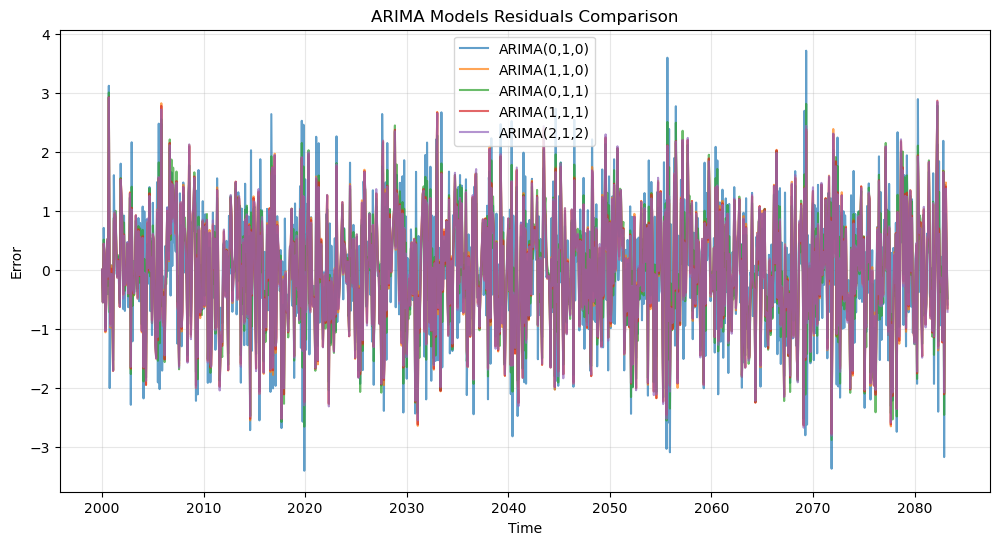

In [321]:
from statsmodels.tsa.arima.model import ARIMA

data = time_series_df['T_points'].dropna()

suggested_models = np.array([
    [0,1,0],
    [1,1,0],
    [0,1,1],
    [1,1,1],
    [2,1,2]
])
results = []
error_dfs = []  
fitted_models = []
for p, d, q in suggested_models:
    model = ARIMA(data, order=(p, d, q))
    fitted = model.fit()
    
    results.append({
        'order': f"ARIMA({p},{d},{q})",
        'aic': fitted.aic,
        'bic': fitted.bic,
        'p': p,
        'd': d,
        'q': q
    })
    
    print(f"\nARIMA({p},{d},{q}):")
    print(f"AIC: {fitted.aic:.2f}")
    print(f"BIC: {fitted.bic:.2f}")
    
    
    # Get residuals and add to list
    residuals = pd.DataFrame(fitted.resid)
    residuals.columns = [f'ARIMA({p},{d},{q})']
    error_dfs.append(residuals)
    
    
    # Store the fitted model object
    fitted_models.append(fitted)
    
    
# Combine all residuals into one DataFrame
all_errors = pd.concat(error_dfs, axis=1)


# Create a DataFrame for the fitted models
fitted_models_df = pd.DataFrame({
    'model_order': [f"ARIMA({p},{d},{q})" for p, d, q in suggested_models],
    'fitted_model': fitted_models
})

# Plot using matplotlib
plt.figure(figsize=(12, 6))
for column in all_errors.columns:
    plt.plot(all_errors.index, all_errors[column], label=column, alpha=0.7)
plt.legend()
plt.title('ARIMA Models Residuals Comparison')
plt.xlabel('Time')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)
plt.show()

#plot_series(all_errors['ARIMA(1,1,1)'], "timeseries of residuals")


        

### Verify 8 supuestos

#### Tests on residuals


In [322]:

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro, jarque_bera, ttest_1samp
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
import statsmodels.stats.weightstats as smw

# Example residuals DataFrame (assuming you've created it as `all_errors` before)
# all_errors contains residuals for each ARIMA model
# Iterate over each model's residuals and perform tests

# Initialize a list to store the test results
residuals_tests = []

data = time_series_df['T_points'].dropna()

# Function to test residuals
def test_residuals(residuals, model_name, alpha = 0.05):
    results = {}
    # 1. Test if 
    # Perform a t-test to check if the mean is significantly different from 0
    p_value = ttest_1samp(residuals, 0).pvalue
    results['mean_close_to_0'] = p_value > alpha  # Within tolerance
    print(f"{model_name}: Mean of residuals = {np.mean(residuals):.4f}, p_value = {p_value:.4f}")
    

    # 2. Check for constant variance (Homoscedasticity) using Breusch-Pagan test
    _, pvalue, _, _ = het_breuschpagan(residuals, sm.add_constant(np.arange(len(residuals))))
    results['constant_variance'] = pvalue > alpha
    print(f"{model_name}: Homoscedasticity (Breusch-Pagan p-value) = {pvalue:.4f}")

    # 3. Normality Tests
    # Shapiro-Wilk test
    _, shapiro_pvalue = shapiro(residuals)
    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(residuals)
    results['normal_distribution'] = shapiro_pvalue > alpha and jb_pvalue > alpha
    print(f"{model_name}: Normality (Shapiro-Wilk p-value) = {shapiro_pvalue:.4f}")
    print(f"{model_name}: Normality (Jarque-Bera p-value) = {jb_pvalue:.4f}")

    # 4. Independence Test using Ljung-Box test
    # Setting a maximum lag of 10 (adjust as necessary)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    pvalue_ljungbox = lb_test['lb_pvalue'].values[0]
    results['independent_errors'] = pvalue_ljungbox > alpha
    print(f"{model_name}: Independence (Ljung-Box p-value) = {pvalue_ljungbox:.4f}")

    # Store results in the residuals_tests list
    residuals_tests.append({'model': model_name, 'results': results})
    if False:
        # Additional Plots
        plt.figure(figsize=(10, 6))
    
        # Histogram and Q-Q plot
        plt.subplot(1, 2, 1)
        plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'{model_name} Residuals Histogram')
        plt.axvline(x=0, color='red', linestyle='--', label='Mean = 0')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        sm.qqplot(residuals, line='s')
        plt.title(f'{model_name} Q-Q Plot')
    
        plt.tight_layout()
        plt.show()
    
    print("-" * 40)
    
    
# Iterate over each column in all_errors DataFrame
for column in all_errors.columns:
    print("column", column)
    residuals = all_errors[column].dropna()  # Drop NaNs if they exist
    test_residuals(residuals, column)

# Print summary of results
print("\nSummary of Residuals Assumptions Check:")
for result in residuals_tests:
    model_name = result['model']
    tests = result['results']
    print(f"{model_name}:")
    print(f"  Mean close to 0: {'Pass' if tests['mean_close_to_0'] else 'Fail'}")
    print(f"  Constant Variance: {'Pass' if tests['constant_variance'] else 'Fail'}")
    print(f"  Normal Distribution: {'Pass' if tests['normal_distribution'] else 'Fail'}")
    print(f"  Independent Errors: {'Pass' if tests['independent_errors'] else 'Fail'}")
    print("-" * 40)
#

column ARIMA(0,1,0)
ARIMA(0,1,0): Mean of residuals = -0.0129, p_value = 0.7257
ARIMA(0,1,0): Homoscedasticity (Breusch-Pagan p-value) = 0.0649
ARIMA(0,1,0): Normality (Shapiro-Wilk p-value) = 0.2787
ARIMA(0,1,0): Normality (Jarque-Bera p-value) = 0.3050
ARIMA(0,1,0): Independence (Ljung-Box p-value) = 0.0000
----------------------------------------
column ARIMA(1,1,0)
ARIMA(1,1,0): Mean of residuals = -0.0189, p_value = 0.5560
ARIMA(1,1,0): Homoscedasticity (Breusch-Pagan p-value) = 0.1548
ARIMA(1,1,0): Normality (Shapiro-Wilk p-value) = 0.0298
ARIMA(1,1,0): Normality (Jarque-Bera p-value) = 0.0911
ARIMA(1,1,0): Independence (Ljung-Box p-value) = 0.4794
----------------------------------------
column ARIMA(0,1,1)
ARIMA(0,1,1): Mean of residuals = -0.0220, p_value = 0.5013
ARIMA(0,1,1): Homoscedasticity (Breusch-Pagan p-value) = 0.0680
ARIMA(0,1,1): Normality (Shapiro-Wilk p-value) = 0.0312
ARIMA(0,1,1): Normality (Jarque-Bera p-value) = 0.0432
ARIMA(0,1,1): Independence (Ljung-Box p-v

### Supuesto 5: Modelo Parsimonioso

In [323]:
# Create lists to store models that pass and fail the test
models_pass = []
models_fail = []

# Iterate over each fitted model in the DataFrame
for index, row in fitted_models_df.iterrows():
    # Get the model order and fitted model object
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Get the confidence intervals for the parameters
    conf_intervals = fitted_model.conf_int()
    
    print(f"\nParameters for {model_order}:")
    print(parameters)
    
    print(f"\nConfidence Intervals for {model_order}:")
    print(conf_intervals)
    print("-" * 50)
    
    # Check if all confidence intervals do not contain zero
    intervals_do_not_contain_zero = (conf_intervals[0] > 0) | (conf_intervals[1] < 0)
    
    if intervals_do_not_contain_zero.all():
        # If all parameters' confidence intervals do not contain zero
        models_pass.append(model_order)
    else:
        # If any parameter's confidence interval contains zero
        models_fail.append(model_order)

# Print the results
print("\nSummary of ARIMA Model Significance Test Based on Confidence Intervals:")
print("===================================================")
print("Models that Passed (Confidence Intervals do NOT contain zero):")
print(models_pass)
print("\nModels that Failed (Confidence Intervals contain zero):")
print(models_fail)



Parameters for ARIMA(0,1,0):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(0,1,0):
               0         1
sigma2  1.222373  1.471269
--------------------------------------------------

Parameters for ARIMA(1,1,0):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(1,1,0):
               0         1
ar.L1  -0.540564 -0.433866
sigma2  0.928990  1.124268
--------------------------------------------------

Parameters for ARIMA(0,1,1):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(0,1,1):
               0         1
ma.L1  -0.482452 -0.369867
sigma2  0.969462  1.176856
--------------------------------------------------

Parameters for ARIMA(1,1,1):
ar.L1    -0.159288
ma.L1     0.531964
sigma2    0.965557
dtype: float64

Confidence Intervals for ARIMA(1,1,1):
               0         1
ar.L1  -0.554244 -0.332609
ma.L1  -0

### Supuesto 6, modelos crean seria estationario

In [324]:
# Create lists to store models that pass and fail the stationary test
stationary_models = []
non_stationary_models = []

# Iterate over each fitted model in the DataFrame
for index, row in fitted_models_df.iterrows():
    # Get the model order and fitted model object
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Get the MA polynomial from the model's parameters
    
    
    # Get the MA parameters from the model's parameters
    ma_params = [param for param in fitted_model.params.index if 'ma.L' in param]
    
    
    # Extract the MA parameter values
    ma_coefficients = [fitted_model.params[param] for param in ma_params]
    
    # Compute the roots of the MA polynomial: 1 - p1*x - p2*x^2 - ...
    ma_roots = np.roots(([1] + [-coeff for coeff in ma_coefficients])[::-1])  # Coefficients are negated
    
    # Check if all roots are outside the unit circle (i.e., absolute value > 1)
    if np.all(np.abs(ma_roots) > 1):
        stationary_models.append(model_order)
    else:
        non_stationary_models.append(model_order)

# Print the results
print("\nSummary of Stationarity Test Based on MA Polynomial Roots:")
print("===================================================")
print("Models that Passed (Stationary Models with Roots Outside the Unit Circle):")
print(stationary_models)
print("\nModels that Failed (Non-Stationary Models with Roots Inside or on the Unit Circle):")
print(non_stationary_models)


Summary of Stationarity Test Based on MA Polynomial Roots:
Models that Passed (Stationary Models with Roots Outside the Unit Circle):
['ARIMA(0,1,0)', 'ARIMA(1,1,0)', 'ARIMA(0,1,1)', 'ARIMA(1,1,1)', 'ARIMA(2,1,2)']

Models that Failed (Non-Stationary Models with Roots Inside or on the Unit Circle):
[]


### TODO supuestos 7 y 8

In [325]:
# todo

## Calculate the Forecast and confidence intervalls

In [326]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the number of periods to forecast and the confidence level
n_periods = 10  # Number of periods you want to forecast
confidence_level = 0.2  # Confidence level (e.g., 0.95 for 95%)

portion_of_data = int(1.5 * n_periods)  # The portion of original data to show

# List of models to use
models_to_forecast = ['ARIMA(1,1,1)', 'ARIMA(1,1,0)']

def forecast(data, models_to_forecast, n_periods, original_forecast = None, lmbda = None):
    # if lmbda not is none, inverse box cox transformation will be apllied
    
    
    forecast_results = {}
    
    # Retrieve the last portion of the original data
    
    data_to_plot = data[-portion_of_data:]
    
    # Iterate over each model in the DataFrame and forecast
    for model_name in models_to_forecast:
        # Retrieve the fitted model from the DataFrame
        fitted_model = fitted_models_df.loc[fitted_models_df['model_order'] == model_name, 'fitted_model'].iloc[0]
        
        # Forecast the next n periods with the specified confidence level
        forecast = fitted_model.get_forecast(steps=n_periods)
        
        # Get the predicted mean and confidence intervals
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int(alpha=1 - confidence_level)  # Adjust alpha for the confidence interval
        
        # Store the forecast results for plotting
        forecast_results[model_name] = {
            'forecast_mean': forecast_mean,
            'forecast_ci': forecast_ci
        }
        
        # Print the forecasted values and confidence intervals
        print(f"\nForecast for {model_name} for the next {n_periods} periods with {confidence_level*100:.1f}% Confidence Interval:")
        print(forecast_mean)
        print("\nConfidence Interval:")
        print(forecast_ci)
        
    # Plot the forecasts from both models
    plt.figure(figsize=(14, 8))
    
    # Plot the last portion of the original data
    plt.plot(data_to_plot.index, data_to_plot, label='Differed Data', color='blue')
    
    # Create a date range for the forecasted periods
    forecast_index = pd.date_range(start=data.index[-1], periods=n_periods+1, freq='MS')[1:]
    
    # Plot forecasts and confidence intervals for each model
    colors = {'ARIMA(1,1,1)': 'green', 'ARIMA(1,1,0)': 'orange'}
    
    for model_name, result in forecast_results.items():
        forecast_mean = result['forecast_mean']
        forecast_ci = result['forecast_ci']
        
        # Plot forecasted values
        plt.plot(forecast_index, forecast_mean, label=f'Forecast - {model_name}', color=colors[model_name], marker='o')
        
        # Plot confidence intervals
        plt.fill_between(forecast_index,
                         forecast_ci.iloc[:, 0],
                         forecast_ci.iloc[:, 1],
                         color=colors[model_name], alpha=0.2)
    
    # Finalize the plot
    plt.title(f'Forecast Comparison for ARIMA(1,1,1) and ARIMA(1,1,0) with {confidence_level*100:.1f}% Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
forecast(time_series_df['T_points'].dropna(), models_to_forecast)


TypeError: forecast() missing 1 required positional argument: 'n_periods'